# Energy Use 2

Analysing household energy use

Notes:

  - Updated to use the latest data from Octopus (not 'historical' and 'current' data as per the v1 script).
  - Expects a file called `data/consumption.csv`. This isn't stored in github but can be copied over from my dropbox (`research/geeky/octopus_data/consumption.csv`).

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt# Import a scoring metric to compare methods
import seaborn as sns

from datetime import timedelta, datetime

## Read Data

Consumption data downloaded from octopus.
 
Also add a cost column. Current prices are:
  - £0.0810 from 00:30 - 04:30
  - £0.2122 all other times
  - £0.6226 standing charge per day
 
TODO
 - [ ] Automate collection from this page https://octopus.energy/dashboard/new/accounts/A-ADD72A6B/consumption/home
 

In [2]:
price_daytime = 0.2122
price_overnight = 0.0810
standing_charge = 0.6226

# A lookup with energy prices in half-hourly time slots
price_lookup = [price_daytime] + [price_overnight] * 8 + [price_daytime] * 39

def calc_tarrif(row, price_lookup = price_lookup, cost=False, _standing_charge=standing_charge):
    """Given a row of data, use the date (row index), energy use and price lookup
    to calculate the actual cost of energy (if cost=True) or the tarrif used (if cost=False).
    The standing charge is total cost in £ for a day and a 30 minute portion of that
    is added to the cost."""
    assert len(price_lookup) == 48, f"Price lookup should have 48 items, not: {len(price_lookup)}"
    date = row.name # Stupidly the index is referenced using 'name' in pandas
    energy = row.energy
    # Find the tarrif for this half hourly slot. Multiply decimal hour by 2
    price_index = int( (date.hour + (date.minute / 60) ) * 2 )
    #print(date, price_index, ( date.hour + (date.minute / 60) ) * 2, price_lookup[price_index])
    tarrif = price_lookup[price_index]
    if cost:
        return tarrif * energy + ( _standing_charge / 48.0 )  # add 30 mins of standing charge
    else:
        return tarrif

def read_data(filename):
    """Process to read and clean data is the same for historical and latest datasets"""
    raw_data = pd.read_csv(os.path.join("data", filename))
    
    # Drop whitespace
    raw_data[' Start'] = raw_data[' Start'].apply(lambda x: x.strip())
    raw_data[' End'] = raw_data[' End'].apply(lambda x: x.strip())

    raw_data['energy'] = raw_data['Consumption (kWh)'] # Better column label

    # Create date objects
    # Do it properly, but the time offset is really annoying!
    #raw_data['StartDate'] = pd.to_datetime(raw_data[' Start'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    #raw_data['EndDate'] =  pd.to_datetime(raw_data[' End'], format='%Y-%m-%dT%H:%M:%S%z', utc=True)
    # Ignore the time offset by splitting on the '+'
    raw_data['StartDate'] = raw_data[' Start'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )
    raw_data['EndDate']     = raw_data[' End'].apply(lambda x: pd.to_datetime(x.split('+')[0], format='%Y-%m-%dT%H:%M:%S') )

    # Index is the start point for 30 minute interval
    #raw_data['Date'] = raw_data['StartDate']
    #raw_data = raw_data.set_index('Date')
    raw_data.index = pd.DatetimeIndex(raw_data.StartDate)
    raw_data.index.name = "Date"

    # Now just take the columns that we want
    raw_data = raw_data.loc[:,['energy']]
    
    # Add tarrif and cost columns 
    raw_data['tarrif'] = raw_data.apply(calc_tarrif, axis=1, cost=False)
    raw_data['cost'] = raw_data.apply(calc_tarrif, axis=1, cost=True)

    # Make some useful ones
    #df['Day'] = df.index.map(lambda x:x.day) # (had to do it this way before I had the DateTimeIndex set up properly)
    raw_data['day'] = raw_data.index.day
    raw_data['month'] = raw_data.index.month
    raw_data['year'] = raw_data.index.year
    raw_data['dayofyear'] = raw_data.index.dayofyear
    # Hour as a decimal
    #raw_data['hour'] = raw_data.index.map(lambda x:x.hour) + raw_data.index.map(lambda x:x.minute) / 60
    raw_data['hour'] =  raw_data.index.hour + (raw_data.index.minute / 60)
    # Season (thanks https://stackoverflow.com/questions/44124436/python-datetime-to-season)
    #[x%12 // 3 + 1 for x in range(13)]
    raw_data['season'] = raw_data.index.month%12 // 3 + 1
    return raw_data

# Read the data
df = read_data("consumption.csv")

In [3]:
print(df.columns)
df

Index(['energy', 'tarrif', 'cost', 'day', 'month', 'year', 'dayofyear', 'hour',
       'season'],
      dtype='object')


,energy,tarrif,cost,day,month,year,dayofyear,hour,season
Date,,,,,,,,,
2023-02-01 00:00:00,1.232,0.2122,0.274401,1,2,2023,32,0.0,1
2023-02-01 00:30:00,1.364,0.0810,0.123455,1,2,2023,32,0.5,1
2023-02-01 01:00:00,0.706,0.0810,0.070157,1,2,2023,32,1.0,1
2023-02-01 01:30:00,0.773,0.0810,0.075584,1,2,2023,32,1.5,1
2023-02-01 02:00:00,0.539,0.0810,0.056630,1,2,2023,32,2.0,1
...,...,...,...,...,...,...,...,...,...
2024-08-12 22:30:00,0.142,0.2122,0.043103,12,8,2024,225,22.5,3
2024-08-12 23:00:00,0.080,0.2122,0.029947,12,8,2024,225,23.0,3
2024-08-12 23:30:00,0.085,0.2122,0.031008,12,8,2024,225,23.5,3


Sanity checks

## Sanity check plots

Plot to check the data look sensible

Daily monthly totals

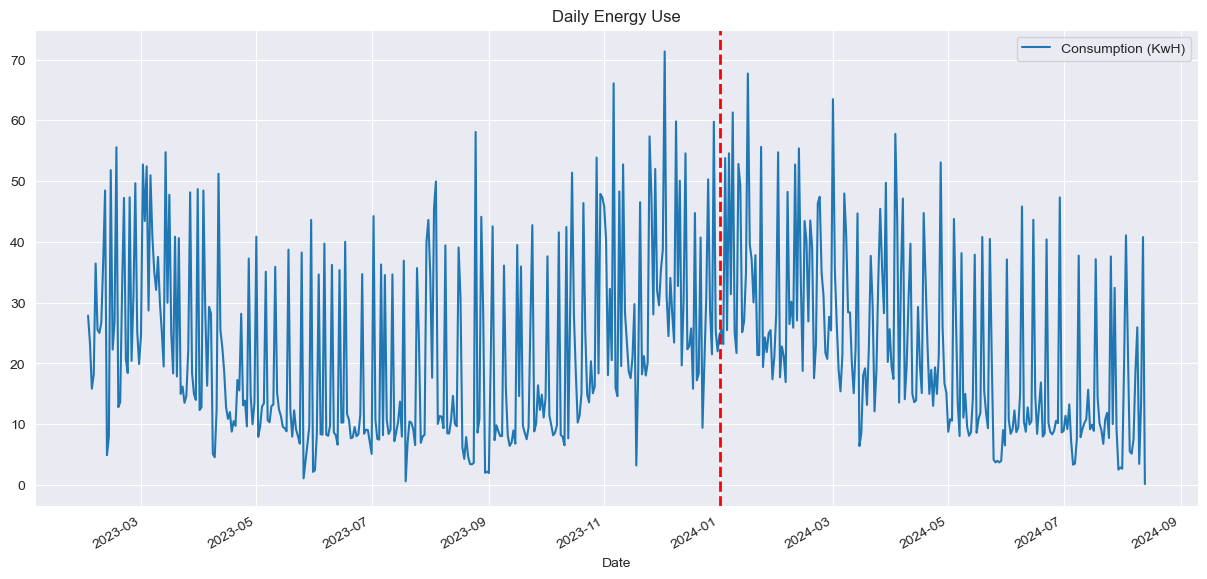

In [4]:
ax = df.groupby(df.index.floor('D'))['energy'].sum().plot(
      figsize=(15, 7), title=f"Daily Energy Use", legend=True, label="Consumption (KwH)")
ax.axvline(x=pd.to_datetime('2024-01-01'), color='red', linestyle='--', linewidth=2, label="January 2024")

Monthly totals

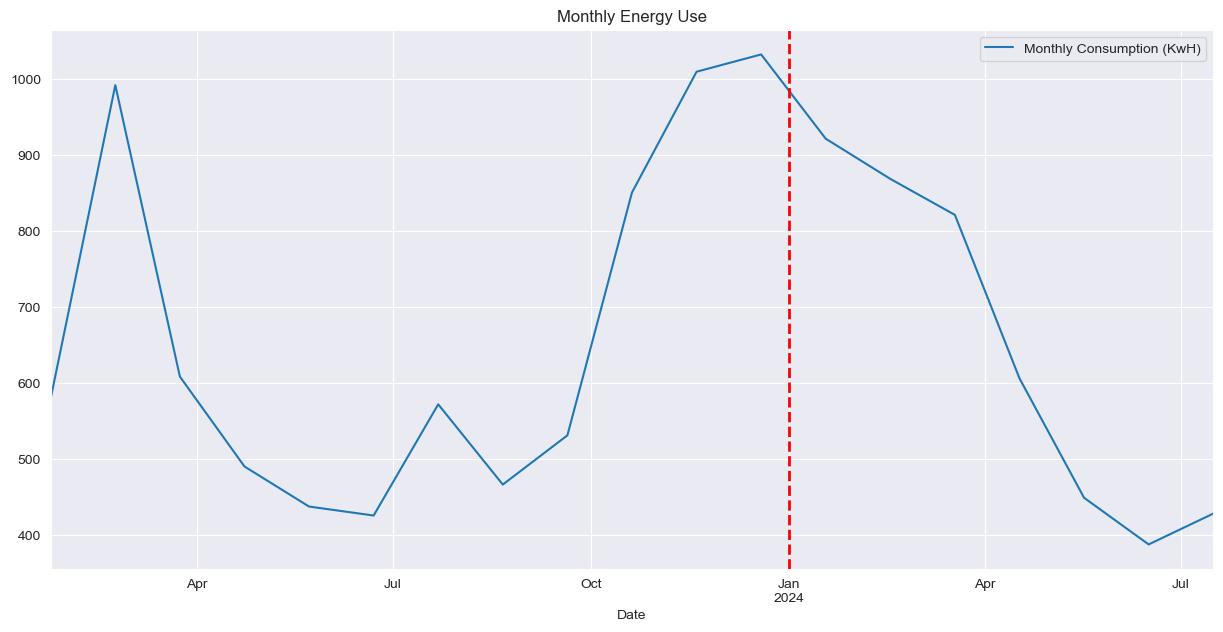

In [5]:
#floor(30D) gives 30 days; approx 1 month
ax = df.groupby(df.index.floor('30D'))['energy'].sum().plot(
        figsize=(15, 7), title=f"Monthly Energy Use", legend=True, label="Monthly Consumption (KwH)")
ax.axvline(x=pd.to_datetime('2024-01-01'), color='red', linestyle='--', linewidth=2, label="January 2024")


One week in May, including tarrif

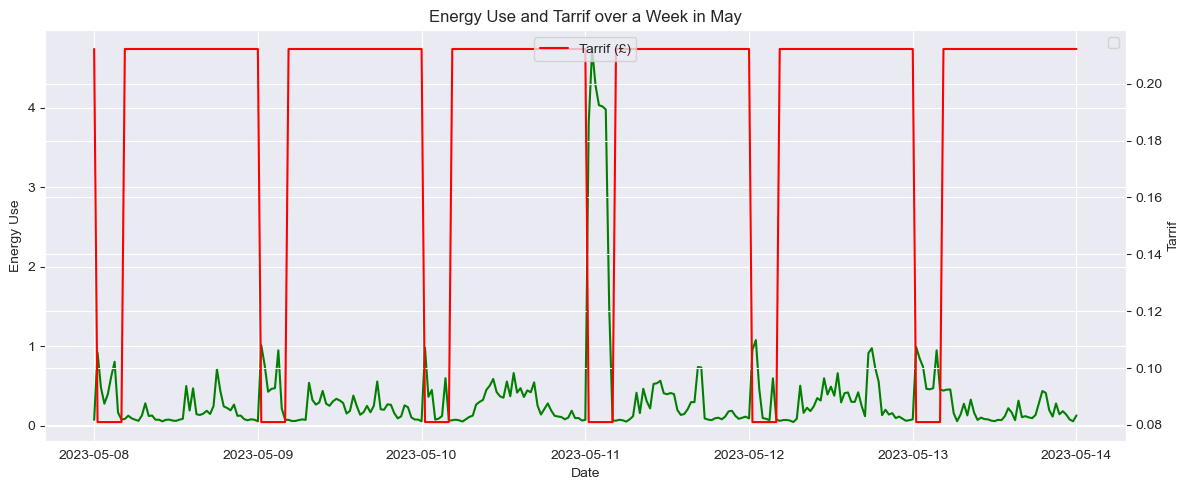

In [6]:
temp = df.loc[datetime.fromisoformat("2023-05-08"):datetime.fromisoformat("2023-05-14"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

#ax.set_xticks(gdp['date'].dt.date)
#ax.set_xticklabels(gdp['date'].dt.year, rotation=90)
#ax.yaxis.grid(color='lightgray', linestyle='dashed')

plt.tight_layout()
plt.show()
#temp.plot(figsize=(15, 7), title="Energy over one week in may (for example)", legend=True, label="energy");
#hist_df.loc[datetime.fromisoformat("2022-05-02 00:00:00+01:00"):datetime.fromisoformat("2022-05-08 23:59:59+01:00"),
#         'energy'].plot(figsize=(15, 7), title="Energy over one week in may (for example)");



Another short week in Dec (mostly to check daylight saving hasn't wrecked things, and to check the latest data)

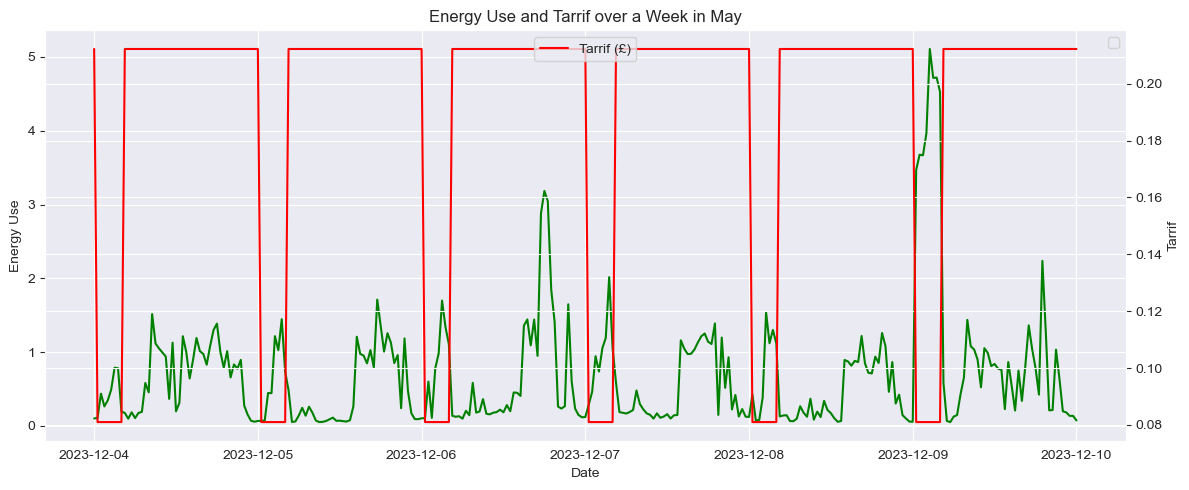

In [7]:
temp = df.loc[datetime.fromisoformat("2023-12-04"):datetime.fromisoformat("2023-12-10"),]


fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title('Energy Use and Tarrif over a Week in May')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Compare a specific time period to a bill that I have (using bill 'A-ADD72A6B-233504098-1.pdf' that I have stored in my dropbox - `research/geeky/octopus_data/`).

In [8]:
bill_consumption = 483.5
bill_cost = 95.38  # (including the standing charge)
bill_time_period = (datetime(2024, 7, 1), datetime(2024, 8, 6, 23, 30))  # (end is inclusive)

df_bill = df.loc[bill_time_period[0]:bill_time_period[1],]

print(f"Consumption (billed, estimated): {bill_consumption} kwh, {round(df_bill.energy.sum(),2)} kwh")
print(f"Cost (billed, estimated): £{bill_cost}, £{round(df_bill.cost.sum(),2)}")

Consumption (billed, estimated): 483.5 kwh, 483.52 kwh
Cost (billed, estimated): £95.38, £97.15


(Very slightly off but I think this is OK)

Finally cut the data so that it has only 12 months

In [9]:
df = df.loc[datetime.fromisoformat("2023-07-01"):datetime.fromisoformat("2024-06-30"),]

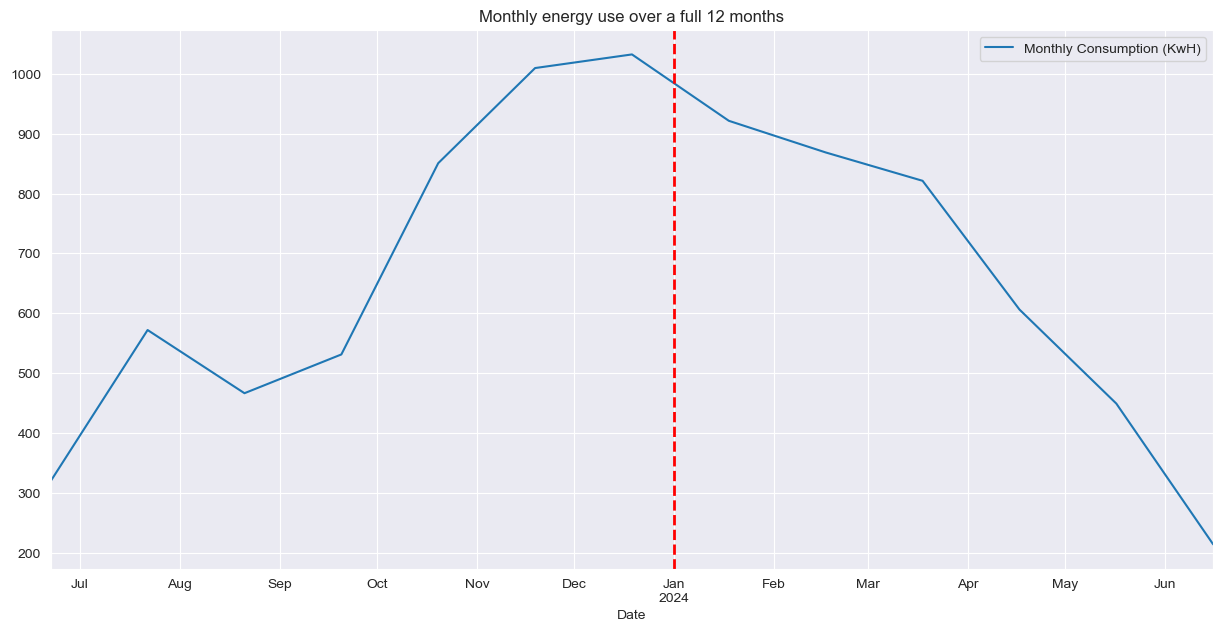

In [10]:
#floor(30D) gives 30 days; approx 1 month
ax = df.groupby(df.index.floor('30D'))['energy'].sum().plot(
    figsize=(15, 7), title=f"Monthly energy use over a full 12 months",
    legend=True, label="Monthly Consumption (KwH)")
ax.axvline(x=pd.to_datetime('2024-01-01'), color='red', linestyle='--', linewidth=2, label="January 2024")


## How much energy is used during the day and overnight?


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


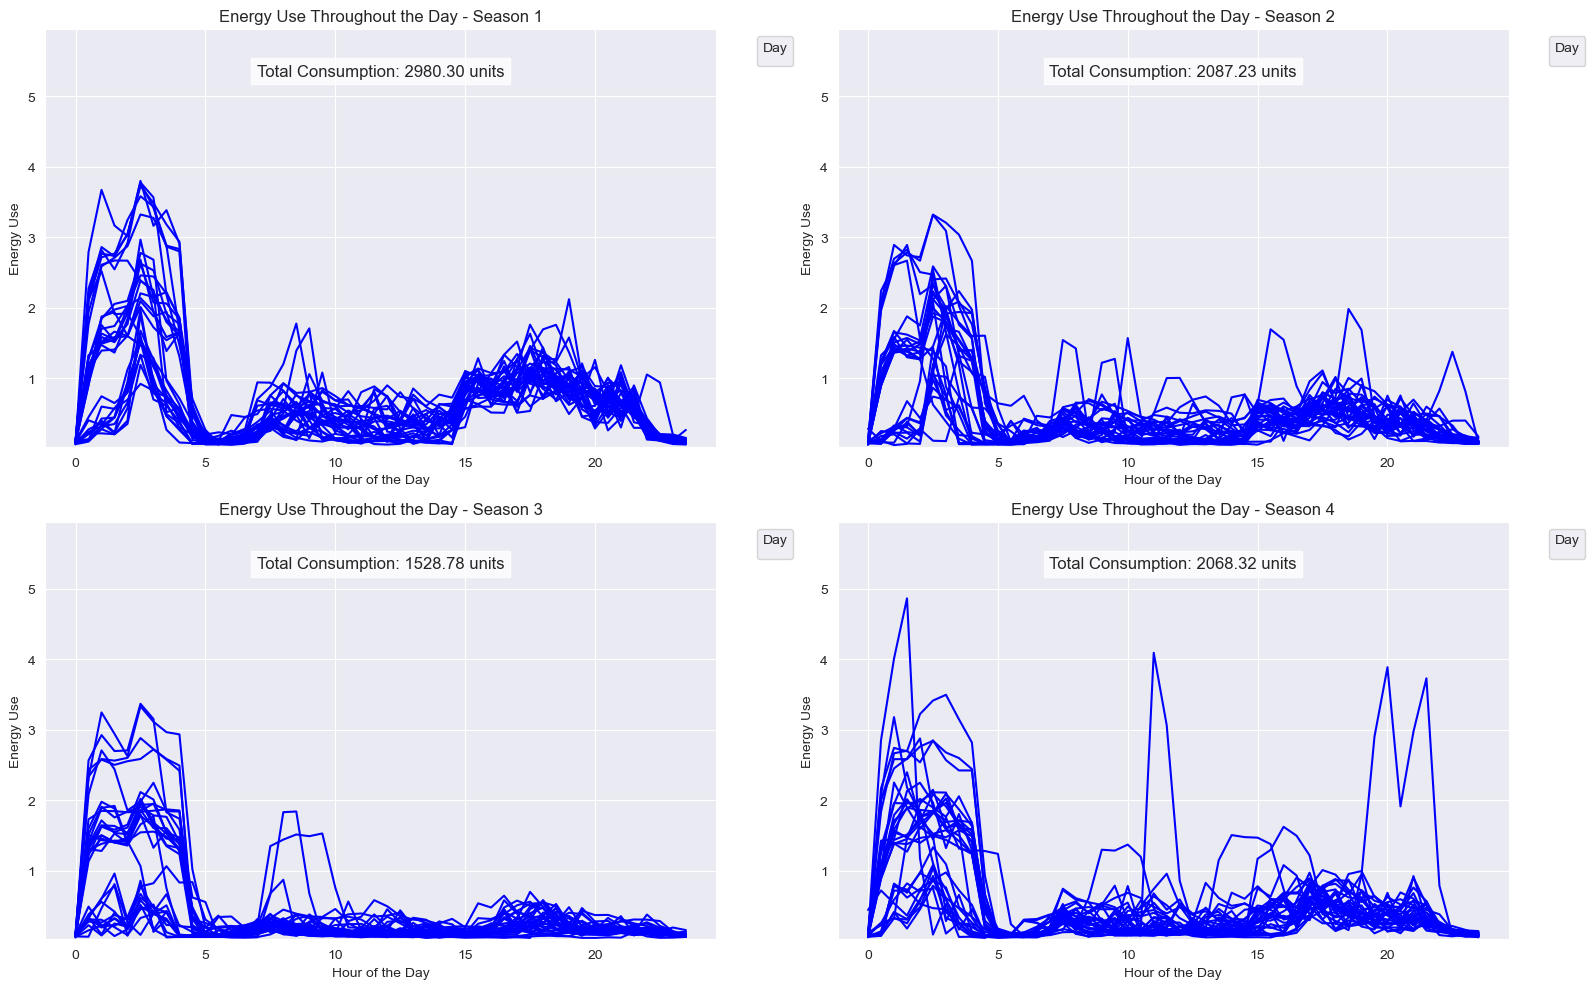

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# Get the list of seasons
seasons = sorted(df['season'].unique())

# Determine the y-axis limits based on the overall data range
ymin = df['energy'].min()
ymax = df['energy'].max()

# Iterate over each season and create a subplot
for i, season in enumerate(seasons):
    ax = axes[i]  # Get the corresponding subplot

    df_season = df[df['season'] == season]

    # Group by day and hour to get the average energy use for each 30-minute period in each day
    daily_energy = df_season.groupby(['day', 'hour'])['energy'].mean().unstack(level=0)

    # Calculate the total consumption for the current season
    total_consumption = df_season['energy'].sum()

    # Plot a line for each day in the current season
    for day in daily_energy.columns:
        ax.plot(daily_energy.index, daily_energy[day], color="blue", alpha=1.0)

    # Set the y-axis limits based on the overall data range
    ax.set_ylim(ymin, ymax)

    # Display the total consumption as text on the plot
    ax.text(0.5, 0.9, f'Total Consumption: {total_consumption:.2f} units',
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Set the title and labels for each subplot
    ax.set_title(f'Energy Use Throughout the Day - Season {season}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Energy Use')
    ax.legend(title='Day', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

## Is the cheap overnight tarrif better in winter?

Look at two weeks in winter and estimate whether an overnight tarrif would have been better than a normal one (because when we're running the heat pump it uses a lot of electricity during the day).

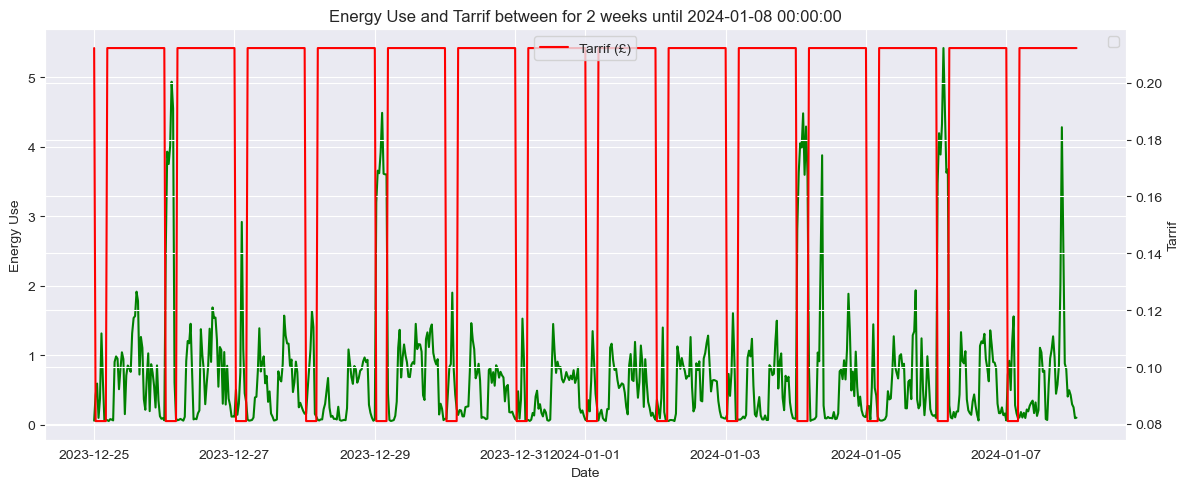

In [12]:
# Cut 2 weeks and plot use and (existing) tarrif

date_now = datetime(2024,1,8,0,0)  # 8th Jan
df_two_weeks = df.loc[date_now-timedelta(weeks=2):date_now]

# Plot 

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title(f'Energy Use and Tarrif between for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(df_two_weeks['energy'], color='green')

ax2.plot(df_two_weeks['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Total cost (actual) and then hypothetical (if on standard tarrif)

In [24]:
# Calculated the cost previously, so can just sum that column
actual_cost_total = df_two_weeks.cost.sum()

# Sanity check (this is the formula used to estimate hypothetical cost in the next chunk)
temp = df_two_weeks.apply(calc_tarrif, axis=1, price_lookup=price_lookup, cost=True)
assert actual_cost_total == temp.sum(), f"Should be equal: {actual_cost_total}, {temp.sum()}" 

print(f"Current (actual) cost over that period is £{round(actual_cost_total)}.")

Current (actual) cost over that period is £89.


In [25]:
# New cost asuming on standard tarrif.

# Hypothetical tarrif is 22.06p all day
hypothetical_price_lookup = [0.2206] * 48

# Calculate that cost
hypothetical_cost = df_two_weeks.apply(calc_tarrif, axis=1,
                                       price_lookup=hypothetical_price_lookup, cost=True)
df_two_weeks = df_two_weeks.assign(hypothetical_cost=hypothetical_cost)

hypothetical_cost_total = df_two_weeks.hypothetical_cost.sum()
print(f"Hypothetical cost over that period is £{round(hypothetical_cost_total)}.")

Hypothetical cost over that period is £114.


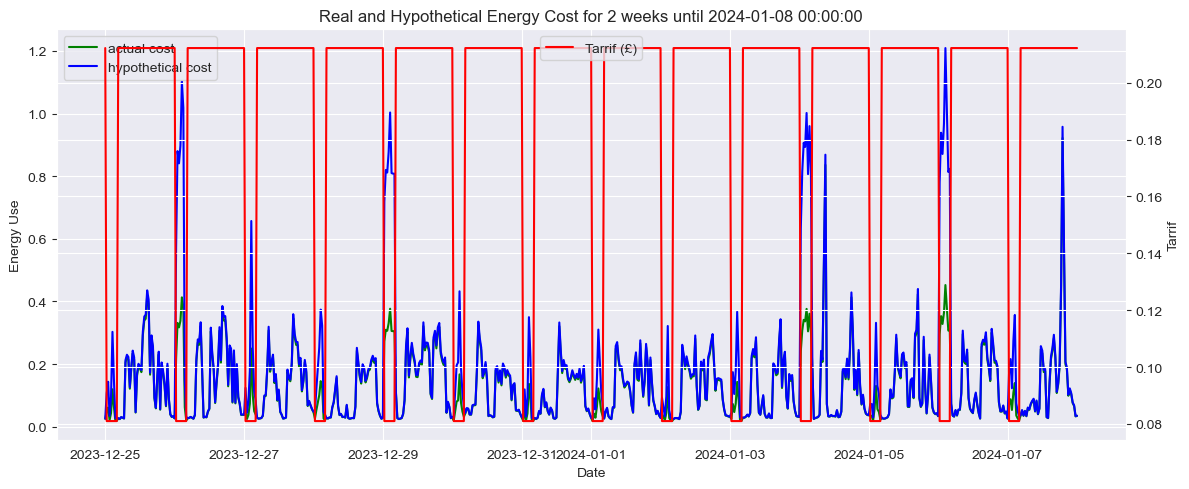

In [26]:
# Plot 

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_title(f'Real and Hypothetical Energy Cost for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.plot(df_two_weeks['cost'], color='green', label="actual cost")
ax.plot(df_two_weeks['hypothetical_cost'], color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

ax2.plot(df_two_weeks['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Look at that cumulatively

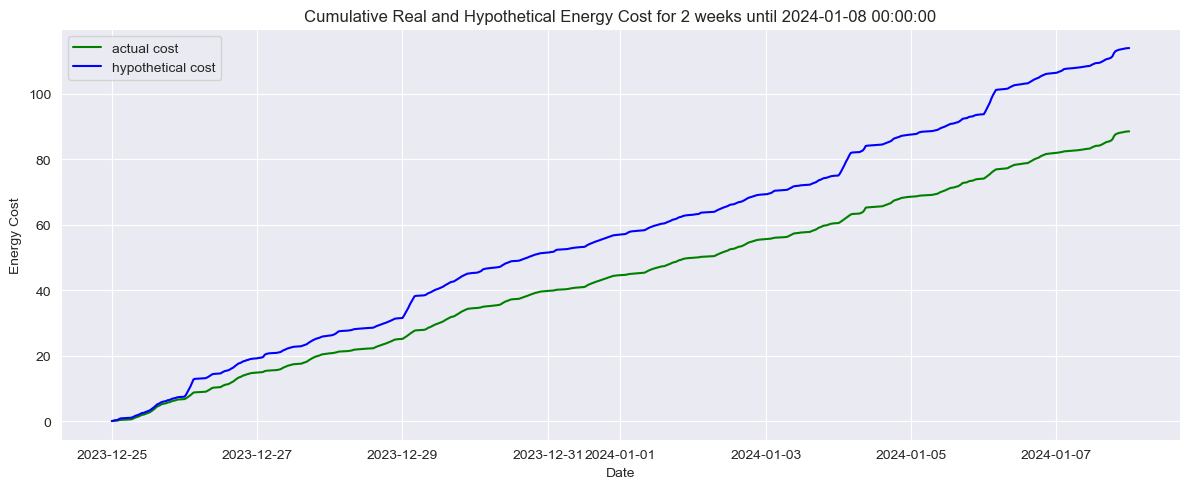

In [27]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title(f'Cumulative Real and Hypothetical Energy Cost for 2 weeks until {date_now}')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Cost')
ax.plot(df_two_weeks['cost'].cumsum(), color='green', label="actual cost")
ax.plot(df_two_weeks['hypothetical_cost'].cumsum(), color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Is the cheap overnight tarrif better over the whole year?

In [28]:
actual_cost_total = df.cost.sum()
hypothetical_cost = df.apply(calc_tarrif, axis=1, price_lookup=hypothetical_price_lookup, cost=True)
df = df.assign(hypothetical_cost=hypothetical_cost)

hypothetical_cost_total = df.hypothetical_cost.sum()
print(f"Costs (actual / hypothetical) over that period are £{round(actual_cost_total)} / £{round(hypothetical_cost_total)}.")

Costs (actual / hypothetical) over that period are £1549 / £2138.


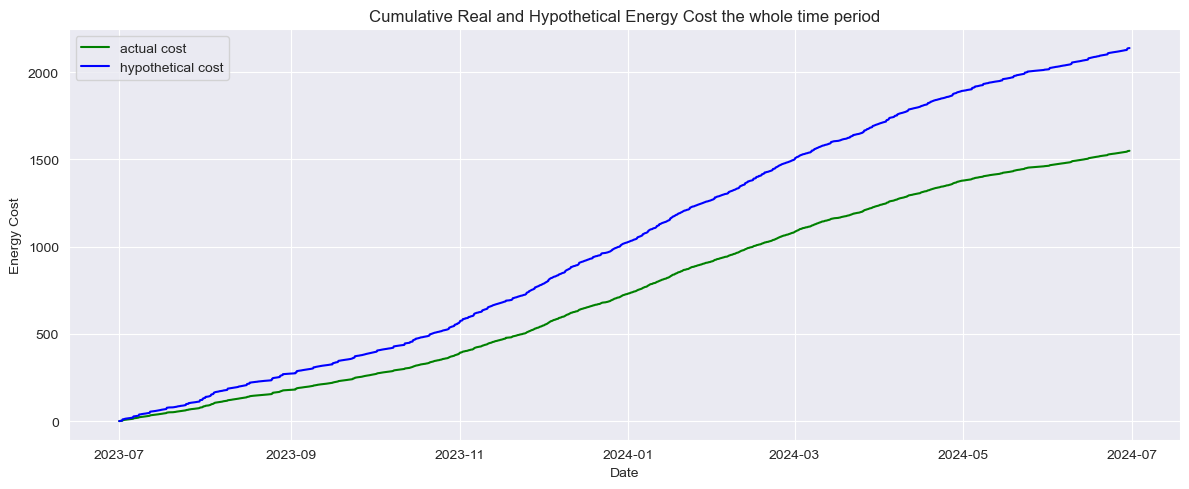

In [29]:
fig, ax = plt.subplots(figsize=(12,5))

ax.set_title(f'Cumulative Real and Hypothetical Energy Cost the whole time period')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Cost')
ax.plot(df['cost'].cumsum(), color='green', label="actual cost")
ax.plot(df['hypothetical_cost'].cumsum(), color='blue', label="hypothetical cost")
#ax.legend(["actual cost", "hypothetical cost"], loc='upper right')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## How much will I save by installing solar panals?

How much energy do I use during the daytime (basically outside of cheap octopus hours)?
(_frequency distribution of use and cost_)

In [30]:
df_daytime = df.between_time('04:30', '00:30', inclusive="neither")
df_daytime

,energy,tarrif,cost,day,month,year,dayofyear,hour,season,hypothetical_cost
Date,,,,,,,,,,
2023-07-01 00:00:00,0.061,0.2122,0.025915,1,7,2023,182,0.0,3,0.026427
2023-07-01 05:00:00,0.209,0.2122,0.057321,1,7,2023,182,5.0,3,0.059076
2023-07-01 05:30:00,0.076,0.2122,0.029098,1,7,2023,182,5.5,3,0.029736
2023-07-01 06:00:00,0.074,0.2122,0.028674,1,7,2023,182,6.0,3,0.029295
2023-07-01 06:30:00,0.067,0.2122,0.027188,1,7,2023,182,6.5,3,0.027751
...,...,...,...,...,...,...,...,...,...,...
2024-06-29 22:00:00,0.176,0.2122,0.050318,29,6,2024,181,22.0,3,0.051796
2024-06-29 22:30:00,0.197,0.2122,0.054774,29,6,2024,181,22.5,3,0.056429
2024-06-29 23:00:00,0.307,0.2122,0.078116,29,6,2024,181,23.0,3,0.080695


Sanity check: the graph below now should just show a single tarrif as there are no night time useage

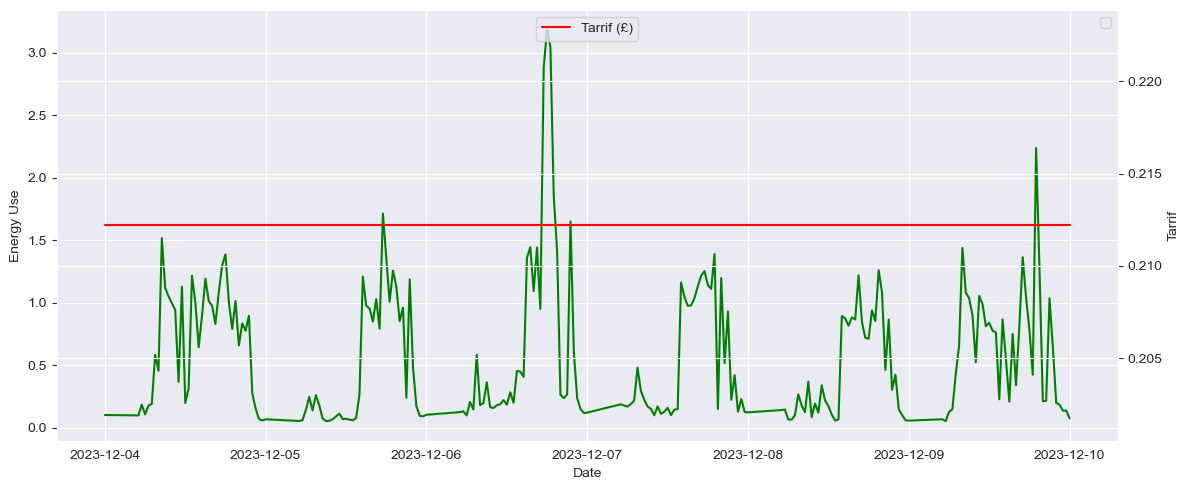

In [31]:
temp = df_daytime.loc[datetime.fromisoformat("2023-12-04"):datetime.fromisoformat("2023-12-10"),]

fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()

ax.set_xlabel('Date')
ax.set_ylabel('Energy Use')
ax.legend(["energy use"])
ax.plot(temp['energy'], color='green')

ax2.plot(temp['tarrif'], color='red')
ax2.set_ylabel('Tarrif')
ax2.legend(['Tarrif (£)'], loc='upper center')

plt.tight_layout()
plt.show()

Plot the distribution of daytime daily cost and consumption.

Mean Daily Cost: £3.18
Mean Daily Consumption: 12.62 KwH


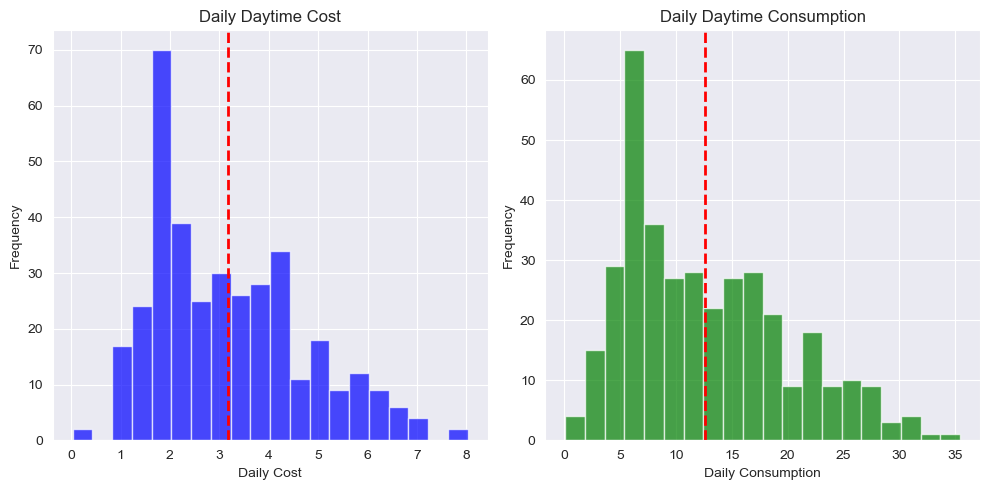

In [32]:
# Group by the date part of the 'Date' index to get daily data
temp = df_daytime.resample('D').agg(
    daily_cost=('cost', 'sum'),
    daily_consumption=('energy', 'sum'),
    season=('season', 'first')
)

# Calculate the mean daily cost and mean daily consumption
mean_daily_cost = temp['daily_cost'].mean()
mean_daily_consumption = temp['daily_consumption'].mean()

print(f"Mean Daily Cost: £{round(mean_daily_cost,2)}")
print(f"Mean Daily Consumption: {round(mean_daily_consumption,2)} KwH")

# Create a histogram for daily cost
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(temp['daily_cost'], bins=20, color='blue', alpha=0.7)
plt.axvline(mean_daily_cost, color='red', linestyle='dashed', linewidth=2)
plt.title('Daily Daytime Cost')
plt.xlabel('Daily Cost')
plt.ylabel('Frequency')

# Create a histogram for daily consumption
plt.subplot(1, 2, 2)
plt.hist(temp['daily_consumption'], bins=20, color='green', alpha=0.7)
plt.axvline(mean_daily_consumption, color='red', linestyle='dashed', linewidth=2)
plt.title('Daily Daytime Consumption')
plt.xlabel('Daily Consumption')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Do that again but break it down by season

Mean Daily Cost: £3.18
Mean Daily Consumption: 12.62 KwH


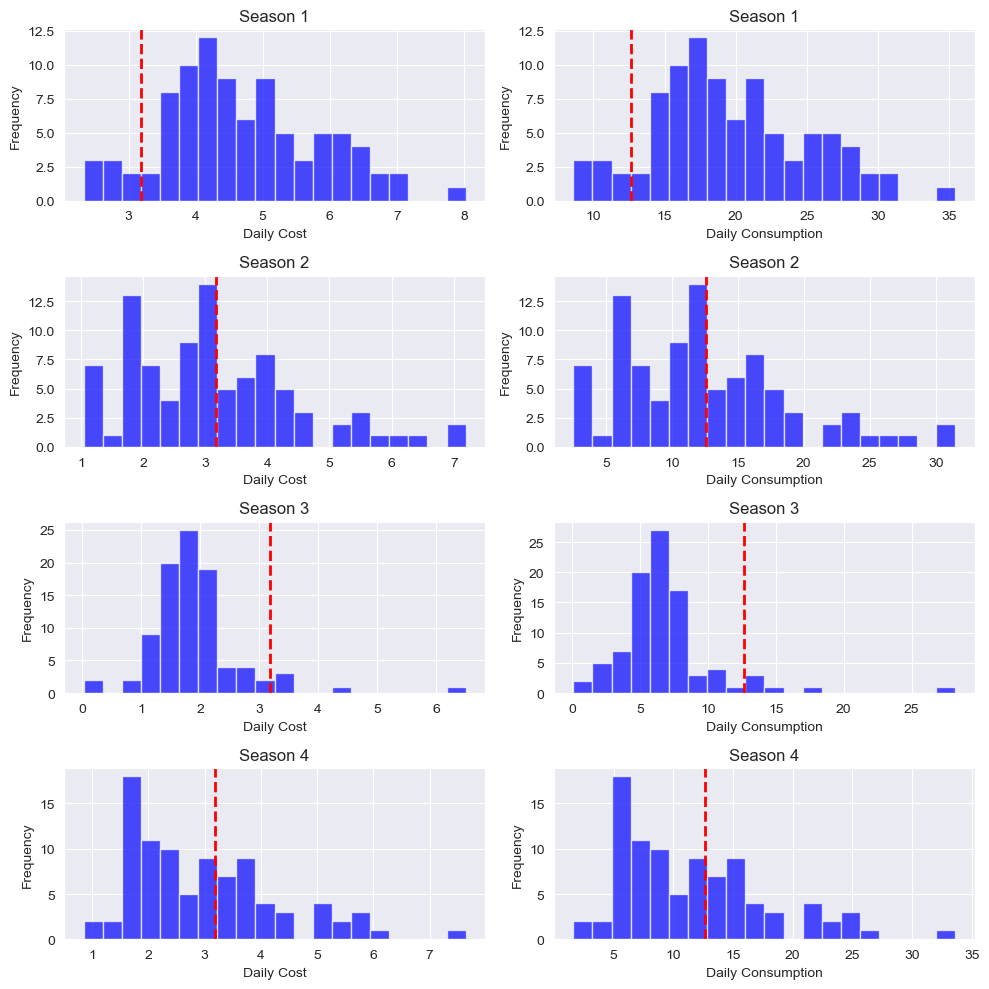

In [33]:
# Group by the date part of the 'Date' index to get daily data
temp = df_daytime.resample('D').agg(
    daily_cost=('cost', 'sum'),
    daily_consumption=('energy', 'sum'),
    season=('season', 'first')
)

# Calculate the mean daily cost and mean daily consumption
mean_daily_cost = temp['daily_cost'].mean()
mean_daily_consumption = temp['daily_consumption'].mean()

print(f"Mean Daily Cost: £{round(mean_daily_cost,2)}")
print(f"Mean Daily Consumption: {round(mean_daily_consumption,2)} KwH")

# Create a histogram for daily cost
fig, axes = plt.subplots(4,2, figsize=(10, 10))
axes = axes.flatten()

# Plot the frequency distributions for each season
counter = 0

for season in sorted(df_daytime.season.unique()):
    ax = axes[counter]
    temp_season = temp[temp['season'] == season]
    ax.hist(temp_season['daily_cost'], bins=20, color='blue', alpha=0.7)
    ax.axvline(mean_daily_cost, color='red', linestyle='dashed', linewidth=2)
    ax.set_title(f'Season {season}')
    ax.set_xlabel('Daily Cost')
    ax.set_ylabel('Frequency')

    counter += 1
    ax = axes[counter]
    ax.hist(temp_season['daily_consumption'], bins=20, color='blue', alpha=0.7)
    ax.axvline(mean_daily_consumption, color='red', linestyle='dashed', linewidth=2)
    ax.set_title(f'Season {season}')
    ax.set_xlabel('Daily Consumption')
    ax.set_ylabel('Frequency')

    counter += 1

plt.tight_layout()
plt.show()

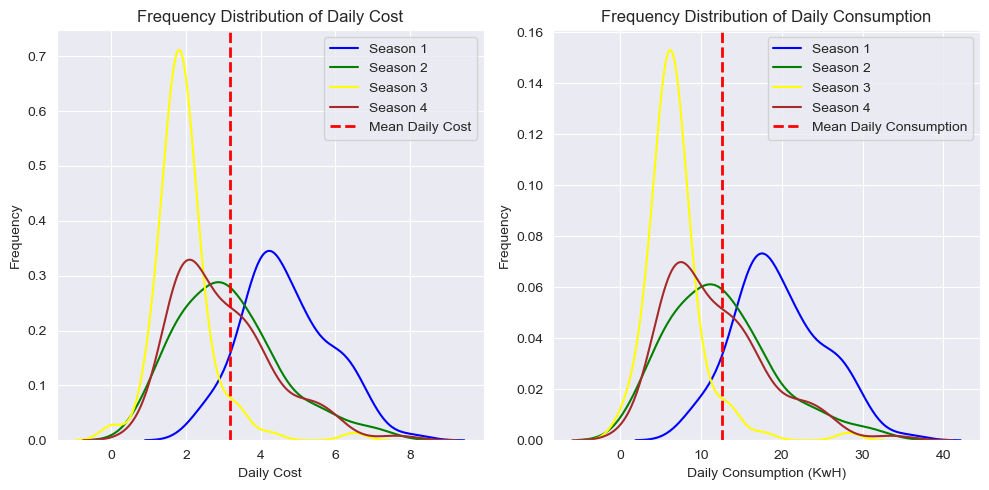

In [23]:
# Prefer bars or density?
use_bars = False

# Create a figure with two subplots: one for daily cost and one for daily consumption
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

alpha = 0.3
# Define colors for each season (1: Spring, 2: Summer, 3: Fall, 4: Winter)
colors = {
    1: 'blue',  # Winter
    2: 'green',  # Spring
    3: 'yellow',  # Summer
    4: 'brown'  # Autumn
}

# Plot the frequency distributions for each season on the same axes
for season in [1,2,3,4]:
    temp_season = temp[temp['season'] == season]

    if use_bars:
        # Plot daily cost distribution
        axes[0].bar(temp_season.index, temp_season['daily_cost'], color=colors[season],
                    alpha=alpha, label=f'Season {season}')

        # Plot daily consumption distribution
        axes[1].bar(temp_season.index, temp_season['daily_consumption'], color=colors[season],
                    alpha=alpha, label=f'Season {season}')
    else:
        sns.kdeplot(temp_season['daily_cost'], color=colors[int(season)], ax=axes[0],
                    label=f'Season {int(season)}')
        sns.kdeplot(temp_season['daily_consumption'], color=colors[int(season)], ax=axes[1],
                    label=f'Season {int(season)}')

# Add mean lines
axes[0].axvline(mean_daily_cost, color='red', linestyle='dashed', linewidth=2, label='Mean Daily Cost')
axes[1].axvline(mean_daily_consumption, color='red', linestyle='dashed', linewidth=2, label='Mean Daily Consumption')

# Set titles and labels
axes[0].set_title('Frequency Distribution of Daily Cost')
axes[0].set_xlabel('Daily Cost')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].set_title('Frequency Distribution of Daily Consumption')
axes[1].set_xlabel('Daily Consumption (KwH)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()